# Quantum Teleportation

This notebook demonstrates quantum teleportation. We first use Qiskit's built-in simulators to test our quantum circuit, and then try it out on a real quantum computer.

## Contents

1. [Overview](#overview)    
2. [The Quantum Teleportation Protocol](#how)       
3. [Simulating the Teleportation Protocol](#simulating)   
    3.1 [How will we Test this Result on a Real Quantum Computer?](#testing)   
    3.2 [Using the Statevector Simulator](#simulating-sv)     
    3.3 [Using the QASM Simulator](#simulating-qs)  
4. [Understanding Quantum Teleportation](#understanding-qt)
5. [Teleportation on a Real Quantum Computer](#real_qc)    
    5.1 [IBM hardware and Deferred Measurement](#deferred-measurement)    
    5.2 [Executing](#executing)    
6. [References](#references)



## 1. Overview <a id='overview'></a>

Alice wants to send quantum information to Bob. Specifically, suppose she wants to send the qubit state
$\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$. 
This entails passing on information about $\alpha$ and $\beta$ to Bob.

There exists a theorem in quantum mechanics which states that you cannot simply make an exact copy of an unknown quantum state. This is known as the no-cloning theorem. As a result of this we can see that Alice can't simply generate a copy of $\vert\psi\rangle$ and give the copy to Bob. We can only copy classical states (not superpositions).

However, by taking advantage of two classical bits and an entangled qubit pair, Alice can transfer her state $\vert\psi\rangle$ to Bob. We call this teleportation because, at the end, Bob will have $\vert\psi\rangle$ and Alice won't anymore.

## 2. The Quantum Teleportation Protocol <a id='how'></a>
To transfer a quantum bit, Alice and Bob must use a third party (Telamon) to send them an entangled qubit pair. Alice then performs some operations on her qubit, sends the results to Bob over a classical communication channel, and Bob then performs some operations on his end to receive Alice’s qubit.

![teleportation_doodle](images/tele1.jpg)

We will describe the steps on a quantum circuit below. Here, no qubits are actually ‘sent’, you’ll just have to imagine that part!

First we set up our session:

In [18]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex

and create our quantum circuit:

In [19]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers

qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

#### Step 1
A third party, Telamon, creates an entangled pair of qubits and gives one to Bob and one to Alice.

The pair Telamon creates is a special pair called a Bell pair. In quantum circuit language, the way to create a Bell pair between two qubits is to first transfer one of them to the X-basis ($|+\rangle$ and $|-\rangle$) using a Hadamard gate, and then to apply a CNOT gate onto the other qubit controlled by the one in the X-basis. 

In [20]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

In [21]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
crx: 1/══════════

Let's say Alice owns $q_1$ and Bob owns $q_2$ after they part ways.

#### Step 2 

Alice applies a CNOT gate to $q_1$, controlled by $\vert\psi\rangle$ (the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to $|\psi\rangle$. In our quantum circuit, the qubit ($|\psi\rangle$) Alice is trying to send is $q_0$:

In [22]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [23]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
crx: 1/═══════════════════════

#### Step 3

Next, Alice applies a measurement to both qubits that she owns, $q_1$ and $\vert\psi\rangle$, and stores this result in two classical bits. She then sends these two bits to Bob.

In [24]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [25]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐   
  q_0: ───────────░───■──┤ H ├─░─┤M├───
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├─░────────────░──╫──╫─
            └───┘ ░            ░  ║  ║ 
crz: 1/═══════════════════════════╩══╬═
                                  0  ║ 
                                     ║ 
crx: 1/══════════════════════════════╩═
                                     0

#### Step 4

Bob, who already has the qubit $q_2$, then applies the following gates depending on the state of the classical bits:

00 $\rightarrow$ Do nothing

01 $\rightarrow$ Apply $X$ gate

10 $\rightarrow$ Apply $Z$ gate

11 $\rightarrow$ Apply $ZX$ gate

(*Note that this transfer of information is purely classical*.)

In [26]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

In [27]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
            └───┘ ░            ░  ║  ║  ░  └─╥─┘  └─╥─┘ 
                                  ║  ║       ║   ┌──╨──┐
crz: 1/═══════════════════════════╩══╬═══════╬═══╡ = 1 ╞
                                  0  ║    ┌──╨──┐└─────┘
crx: 1/══════════════════════════════╩════╡ = 1 ╞═══════
                                     0    └─────┘

And voila! At the end of this protocol, Alice's qubit has now teleported to Bob.

## 3. Simulating the Teleportation Protocol <a id='simulating'></a>

### 3.1 How Will We Test the Protocol on a Quantum Computer? <a id='testing'></a>

In this notebook, we will initialize Alice's qubit in a random state $\vert\psi\rangle$ (`psi`). This state will be created using an `Initialize` gate on $|q_0\rangle$. In this chapter we use the function `random_state` to choose `psi` for us, but feel free to set `psi` to any qubit state you want.

<IPython.core.display.Math object>

/opt/anaconda3/envs/issue1030/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


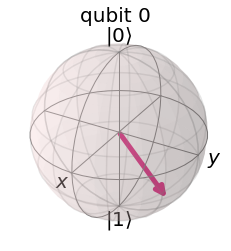

In [34]:
# Create random 1-qubit state
psi = random_state(1)

# Display it nicely
array_to_latex(psi, pretext="|\\psi\\rangle =")
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

Let's create our initialization instruction to create $|\psi\rangle$ from the state $|0\rangle$:

In [35]:
init_gate = Initialize(psi)
init_gate.label = "init"

(`Initialize` is technically not a gate since it contains a reset operation, and so is not reversible. We call it an 'instruction' instead). If the quantum teleportation circuit works, then at the end of the circuit the qubit $|q_2\rangle$ will be in this state. We will check this using the statevector simulator.

### 3.2 Using the Statevector Simulator <a id='simulating-sv'></a>

We can use the statevector simulator to verify our qubit has been teleported.

In [36]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Save state vector
qc.save_statevector()

# Display the circuit
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                  ░ 
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├──────────────────░─
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐               ░ 
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├───────────────░─
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐  ░ 
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├──░─
                ░      └───┘ ░            ░  ║  ║  └─╥─┘  └─╥─┘  ░ 
                                             ║  ║    ║   ┌──╨──┐   
crz: 1/══════════════════════════════════════╩══╬════╬═══╡ = 1 ╞═══
                                             0  ║ ┌──╨──┐└─────┘   
crx: 1/═════════════════════════════════════════╩═╡ = 1 ╞══════════
                                                0 └─────┘

We can see below, using our statevector simulator, that the state of $|q_2\rangle$ is the same as the state $|\psi\rangle$ we created above, while the states of $|q_0\rangle$ and $|q_1\rangle$ have been collapsed to either $|0\rangle$ or $|1\rangle$. The state $|\psi\rangle$ has been teleported from qubit 0 to qubit 2.

/opt/anaconda3/envs/issue1030/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


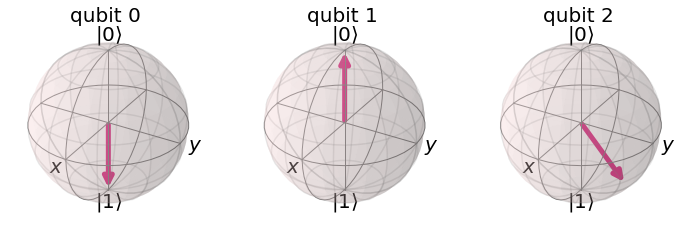

In [37]:
sv_sim = Aer.get_backend('aer_simulator')
qobj = assemble(qc)
out_vector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(out_vector)

You can run this cell a few times to make sure. You may notice that the qubits 0 & 1 change states, but qubit 2 is always in the state $|\psi\rangle$.

### 3.3 Using the QASM Simulator <a id='simulating-qs'></a>

Quantum teleportation is designed to send qubits between two parties. We do not have the hardware to demonstrate this, but we can demonstrate that the gates perform the correct transformations on a single quantum chip. Here we use the QASM simulator to simulate how we might test our protocol.

On a real quantum computer, we would not be able to sample the statevector, so if we wanted to check our teleportation circuit is working, we need to do things slightly differently. The `Initialize` instruction first performs a reset, setting our qubit to the state $|0\rangle$. It then applies gates to turn our $|0\rangle$ qubit into the state $|\psi\rangle$:

$$ |0\rangle \xrightarrow{\text{Initialize gates}} |\psi\rangle $$

Since all quantum gates are reversible, we can find the inverse of these gates using:

In [15]:
inverse_init_gate = init_gate.gates_to_uncompute()

This operation has the property:

$$ |\psi\rangle \xrightarrow{\text{Inverse Initialize gates}} |0\rangle $$

To prove the qubit $|q_0\rangle$ has been teleported to $|q_2\rangle$, if we do this inverse initialization on $|q_2\rangle$, we expect to measure $|0\rangle$ with certainty. We do this in the circuit below:

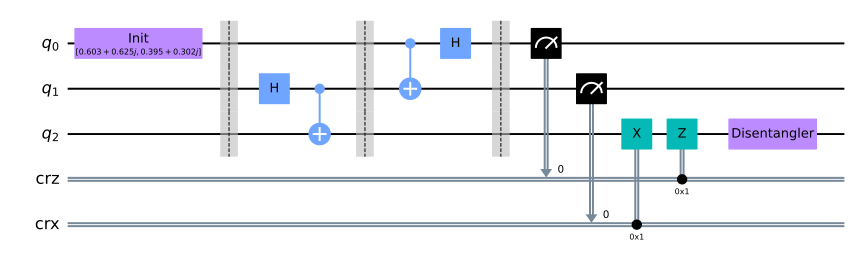

In [16]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

## STEP 5
# reverse the initialization process
qc.append(inverse_init_gate, [2])

# Display the circuit
qc.draw()

We can see the `inverse_init_gate` appearing, labelled 'disentangler' on the circuit diagram. Finally, we measure the third qubit and store the result in the third classical bit:

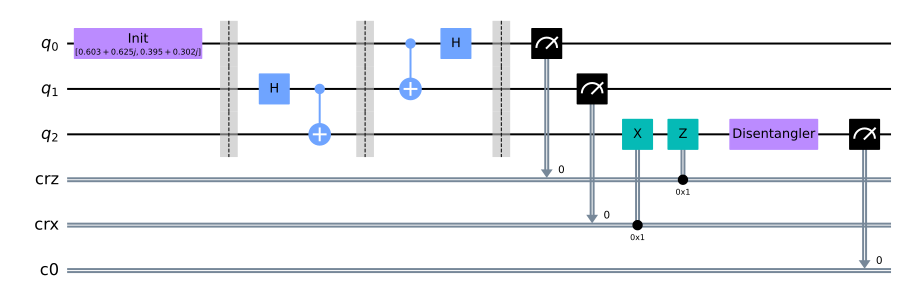

In [17]:
# Need to add a new ClassicalRegister
# to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw()

and we run our experiment:

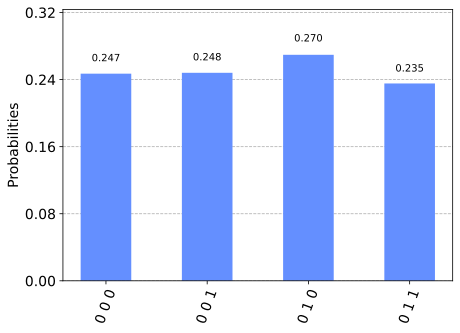

In [18]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
counts = qasm_sim.run(qobj).result().get_counts()
plot_histogram(counts)

We can see we have a 100% chance of measuring $q_2$ (the leftmost bit in the string) in the state $|0\rangle$. This is the expected result, and indicates the teleportation protocol has worked properly.

## 4. Understanding Quantum Teleportation <a id="understanding-qt">

As you have worked with the Quantum Teleportation's implementation, it is time to understand the mathematics behind the protocol.

#### Step 1

Quantum Teleportation begins with the fact that Alice needs to transmit $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$ (a random qubit) to Bob. She doesn't know the state of the qubit. For this, Alice and Bob take the help of a third party (Telamon). Telamon prepares a pair of entangled qubits for Alice and Bob. The entangled qubits could be written in Dirac Notation as:

$$ |e \rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle) $$

Alice and Bob each possess one qubit of the entangled pair (denoted as A and B respectively),

$$|e\rangle = \frac{1}{\sqrt{2}} (|0\rangle_A |0\rangle_B + |1\rangle_A |1\rangle_B) $$

This creates a three qubit quantum system where Alice has the first two qubits and Bob the last one.

$$ \begin{align*}
|\psi\rangle \otimes |e\rangle &= \frac{1}{\sqrt{2}} (\alpha |0\rangle \otimes (|00\rangle + |11\rangle) + \beta |1\rangle \otimes (|00\rangle + |11\rangle))\\
&= \frac{1}{\sqrt{2}} (\alpha|000\rangle + \alpha|011\rangle + \beta|100\rangle + \beta|111\rangle) 
\end{align*}$$

#### Step 2

Now according to the protocol Alice applies CNOT gate on her two qubits followed by Hadamard gate on the first qubit. This results in the state:

$$ 
\begin{align*} (H \otimes I \otimes I) (CNOT \otimes I) (|\psi\rangle \otimes |e\rangle)
&=(H \otimes I \otimes I) (CNOT \otimes I) \frac{1}{\sqrt{2}} (\alpha|000\rangle + \alpha|011\rangle + \beta|100\rangle + \beta|111\rangle) \\
&= (H \otimes I \otimes I) \frac{1}{\sqrt{2}} (\alpha|000\rangle + \alpha|011\rangle + \beta|110\rangle + \beta|101\rangle) \\
&= \frac{1}{2}  (\alpha(|000\rangle + |011\rangle + |100\rangle + |111\rangle) + \beta(|010\rangle + |001\rangle - |110\rangle - |101\rangle)) \\
\end{align*}
$$

Which can then be separated and written as: 

$$
\begin{align*}
= \frac{1}{2}(
 & \phantom{+} |00\rangle (\alpha|0\rangle + \beta|1\rangle) \hphantom{\quad )} \\
 & + |01\rangle (\alpha|1\rangle + \beta|0\rangle) \hphantom{\quad )}\\[4pt]
 & + |10\rangle (\alpha|0\rangle - \beta|1\rangle) \hphantom{\quad )}\\[4pt]
 & + |11\rangle (\alpha|1\rangle - \beta|0\rangle) \quad )\\
\end{align*}
$$

#### Step 3

Alice measures the first two qubit (which she owns) and sends them as two classical bits to Bob. The result she obtains is always one of the four standard basis states $|00\rangle, |01\rangle, |10\rangle,$ and $|11\rangle$ with equal probability.  

On the basis of her measurement, Bob's state will be projected to, 
$$ |00\rangle \rightarrow (\alpha|0\rangle + \beta|1\rangle)\\
|01\rangle \rightarrow (\alpha|1\rangle + \beta|0\rangle)\\
|10\rangle \rightarrow (\alpha|0\rangle - \beta|1\rangle)\\
|11\rangle \rightarrow (\alpha|1\rangle - \beta|0\rangle)$$.

#### Step 4

Bob, on receiving the bits from Alice, knows he can obtain the original state $|\psi\rangle$ by applying appropriate transformations on his qubit that was once part of the entangled pair.

The transformations he needs to apply are:

$$
\begin{array}{c c c}
\mbox{Bob's State}                 & \mbox{Bits Received} & \mbox{Gate Applied} \\
(\alpha|0\rangle + \beta|1\rangle) & 00                   & I                   \\
(\alpha|1\rangle + \beta|0\rangle) & 01                   & X                   \\
(\alpha|0\rangle - \beta|1\rangle) & 10                   & Z                   \\
(\alpha|1\rangle - \beta|0\rangle) & 11                   & ZX
\end{array}
$$

After this step Bob will have successfully reconstructed Alice's state.

## 5. Teleportation on a Real Quantum Computer <a id='real_qc'></a>

### 5.1 IBM hardware and Deferred Measurement <a id='deferred-measurement'></a>

The IBM quantum computers currently do not support instructions after measurements, meaning we cannot run the quantum teleportation in its current form on real hardware. Fortunately, this does not limit our ability to perform any computations due to the _deferred measurement principle_ discussed in chapter 4.4 of [1]. The principle states that any measurement can be postponed until the end of the circuit, i.e. we can move all the measurements to the end, and we should see the same results.

![deferred_measurement_gates](images/defer_measurement.svg)

Any benefits of measuring early are hardware related: If we can measure early, we may be able to reuse qubits, or reduce the amount of time our qubits are in their fragile superposition. In this example, the early measurement in quantum teleportation would have allowed us to transmit a qubit state without a direct quantum communication channel.

While moving the gates allows us to demonstrate the "teleportation" circuit on real hardware, it should be noted that the benefit of the teleportation process (transferring quantum states via classical channels) is lost.

Let us re-write the `bob_gates` function to `new_bob_gates`:

In [19]:
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

And create our new circuit:

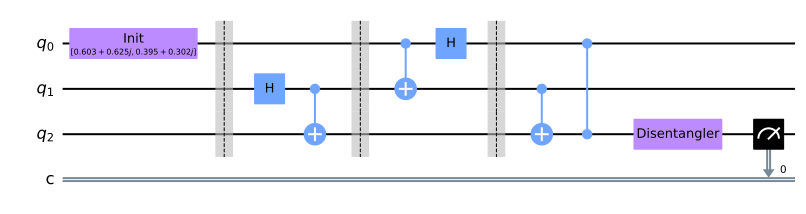

In [20]:
qc = QuantumCircuit(3,1)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw()

### 5.2 Executing <a id='executing'></a> 

In [21]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [22]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(t_qc)
job = backend.run(qobj)
job_monitor(job)  # displays job status under cell

Job Status: job has successfully run


{'0': 968, '1': 56}


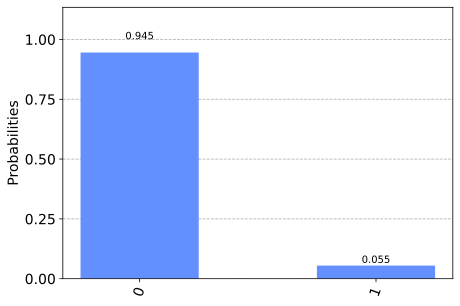

In [26]:
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)

As we see here, there are a few results in which we measured $|1\rangle$. These arise due to errors in the gates and the qubits. In contrast, our simulator in the earlier part of the notebook had zero errors in its gates, and allowed error-free teleportation.

In [29]:
print(f"The experimental error rate : {exp_counts['1']/sum(exp_counts.values()):.3f}%")

The experimental error rate : 0.055%


## 6. References <a id='references'></a>
[1] M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).

[2] Eleanor Rieffel and Wolfgang Polak, Quantum Computing: a Gentle Introduction (The MIT Press Cambridge England, Massachusetts, 2011).

In [30]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}